# Chargement des modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas_datareader as web
import math
import yfinance as yf
import pandas as pd
import seaborn as sns
import seaborn.objects as so
from keras import Input
from keras import layers, Model
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
import random
import sys
sys.path.append('../..')
#import ep.etools as apt
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
from tqdm import tqdm
from pandas.tseries.offsets import DateOffset,BusinessDay

# Lecture des données brutes

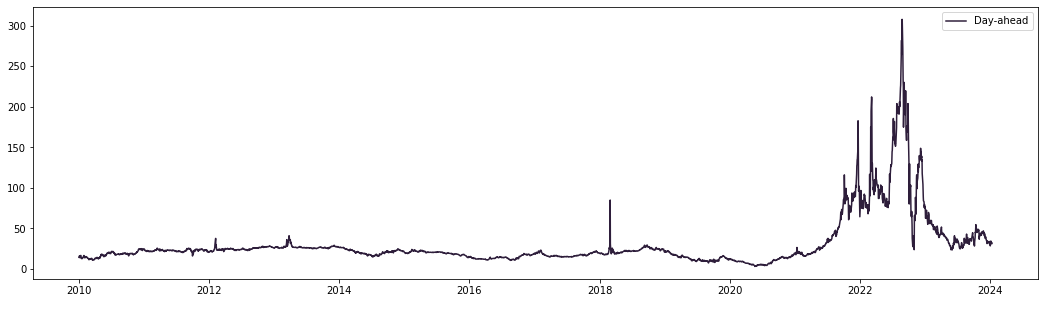

In [2]:
dataCalendar = pd.read_csv('./data/bloc_ttf_calendar_prices.csv')
dataPrices = pd.read_csv('./data/bloc_ttf_prices.csv')
dataPrices[' '] = pd.to_datetime(dataPrices[' '])
dataPrices = dataPrices.set_index(' ')
fig, ax = plt.subplots(figsize=(18,5))
sns.set_palette("mako")
sns.lineplot(dataPrices[['Day-ahead']][0:-1], color='Blue'); #3390
#ax2 = plt.twinx()
#sns.lineplot(data=final['€/$'], ax=ax2 , color='grey')

# Formatage des données
calcul des écarts entre jour J et J-1 en %

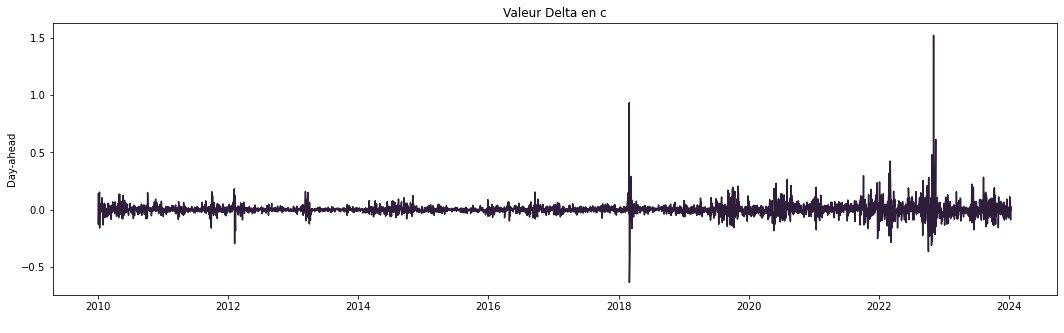

In [3]:
# période de calcul de la volatilité
volatilite = 0 # 260 = 1 an 0=> toutes les données historique
data=dataPrices['Day-ahead'].rolling(2).apply(lambda x: (x.iloc[1] - x.iloc[0])/x.iloc[0])[volatilite:-1]
fig, ax = plt.subplots(figsize=(18,5))
plt.title("Valeur Delta en c")
sns.lineplot(data);


# Comptage

Nombre d'échantillons  2159247


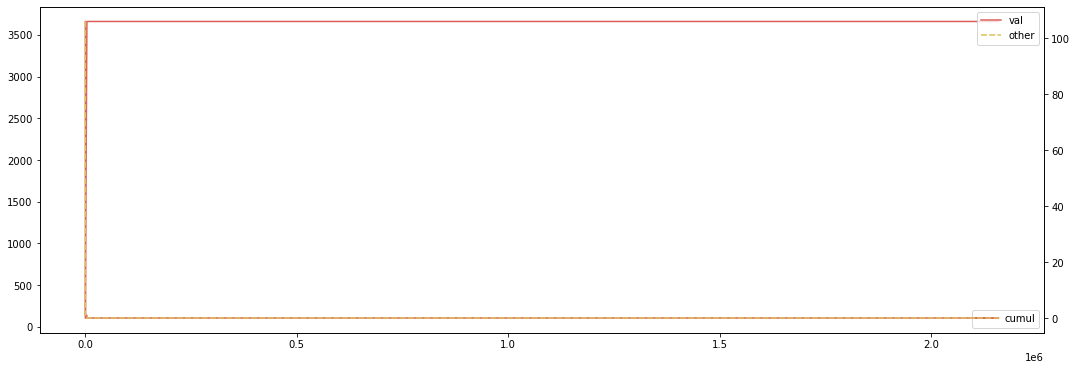

In [4]:
# create intervals
bins = np.arange(data.min(),data.max(),0.000001)
histogramme = np.histogram(data,bins=bins)
histogramme = (np.insert(histogramme[0], histogramme[0].size, 1.0), histogramme[1])
# create a Series, indexed by interval midpoints
pdS = pd.Series(histogramme[0], index=histogramme[1]).to_frame()   #.to_dict()
print("Nombre d'échantillons ",pdS.size)
pdS = pdS.rename(columns={0:'val'})
pdS.sort_values('val',inplace=True,ascending=False)
pdS['other'] = pdS['val'].apply(lambda x: 0.000001 if (x<=0) else x)
pdS['freq'] = pdS.index.values
pdS['cumul'] = pdS['val'].cumsum(skipna=True)
# print(pdS.head(20))
pdS.reset_index(drop=True,inplace=True)
fig, ax = plt.subplots(figsize=(18,6))
# plt.yscale('log')
# plt.xscale('log')
sns.set_palette('hls',8)
sns.lineplot(pdS[['cumul']]);
ax2 = plt.twinx()
sns.lineplot(pdS[['val','other']], ax=ax2);

In [5]:
nbVal = pdS['val'].sum()
randomBase = np.zeros((nbVal,1))
cpt=0
for v in pdS.values:
    nb = int(v[0])
    for i in range(nb):
        randomBase[cpt] = v[2]
        cpt += 1
print(randomBase.size, randomBase[120])

3660 [-0.00500065]


# Interpolation en utilisant un réseau de Neurones

1.5231283530032669


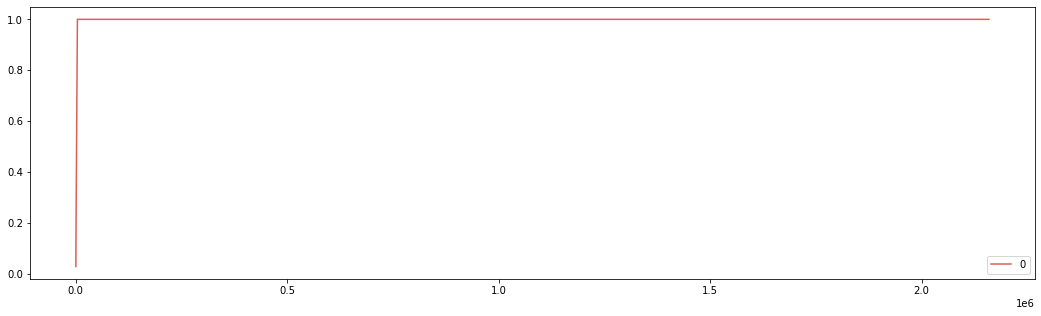

In [6]:
# initialisation des data
X = np.vstack(pdS['cumul'])
y = np.vstack(pdS['freq'])
features_len = 1
# normalisation des data
max = X.max()
X_norm = X / max
max = y.max()
print(max)
max =1.
y_norm = y / max;
fig = plt.figure(figsize=(18,5))
sns.lineplot(X_norm);

In [7]:
# le model Keras
input_data = Input(shape=(1,))
x = layers.Dense(32,activation='sigmoid')(input_data)
# x = layers.GRU(100, dropout=0.2,return_sequences=True, recurrent_dropout=0.5)(input_data)
# x = layers.LSTM(100, dropout=0.1, recurrent_dropout=0.5, return_sequences=True)(input_data)
# x = layers.GRU(32, dropout=0.2,recurrent_dropout=0.5, return_sequences=True)(x)
# x = layers.GRU(32, dropout=0.2,recurrent_dropout=0.5,activation='relu')(x)
# x = layers.Dropout(0.2)(x)
# x = layers.Dense(16,activation='relu')(x)
x = layers.Dense(8,activation='relu')(x)
output_data = layers.Dense(features_len)(x)
# with tf.device("/cpu:0"):
model = Model(input_data,output_data)

optimizer = Adam(learning_rate=0.01)
    # model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['mae','mse])
model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mae'])
model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 32)                64        
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


2024-01-28 21:04:10.499180: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-28 21:04:10.499326: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
epochs = 5
run_dir = './run/'
save_dir = f'{run_dir}/best_model.h5'
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

history = model.fit(X_norm,y_norm,epochs=epochs,verbose=1,shuffle=True,batch_size=16) #,use_multiprocessing=True) #,callbacks = [bestmodel_callback])

fig = plt.figure(figsize=(18,5))
sns.lineplot(history.history);

Epoch 1/5


2024-01-28 21:04:10.846929: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-01-28 21:04:11.018197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  6712/134953 [>.............................] - ETA: 12:14 - loss: 0.3910 - mae: 0.5420

KeyboardInterrupt: 

# Générateur Aléatoire ...

In [9]:
def getRandomValue(df,crit,val,ref,max):
    # r = (np.random.uniform(0,max))
    r = np.random.randint(0,max)
    id = df[crit].loc[lambda x: x>=r].index.min()
    if (id>0):
        v = (df[val][id]-df[val][id-1])*(r-df[crit][id-1])/df[ref][id] + df[val][id-1]
    else:
        v = (df[val][id])*r/df[ref][id]
    return v

In [10]:
def getFastRandom(df,crit,val,ref,max):
    r = (np.random.uniform(0,max))
    id = df[crit].loc[lambda x: x>=r].index.min()
    return df[val][id]

In [11]:
def getOptimRandom(max):
    r = np.random.randint(0,max)
    return randomBase[r]

In [12]:
def getFromModel(nb,max):
    X = np.zeros((nb))
    for i in range(nb):
        r = (np.random.uniform(0,max))
        X[i]=r/max
    X = np.vstack(X)
    return model.predict(x=X)

 96/313 [========>.....................] - ETA: 0s

2024-01-28 21:05:06.242717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step


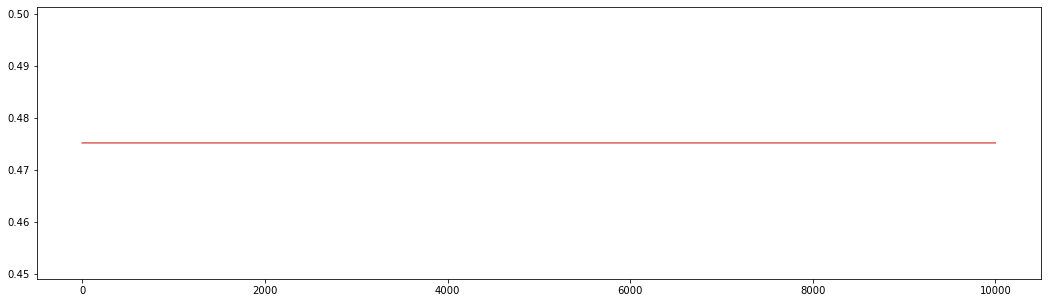

In [13]:
max = pdS['cumul'].max()
simul = getFromModel(10000,max)
# simul = model.predict(X_norm)
fig = plt.figure(figsize=(18,5))
plt.plot(simul);

3660
test unitaire du générateur:  [-0.00290765]
Test sur 100000 échantillons, soit un équivalent de 385 années


100%|██████████| 100000/100000 [00:00<00:00, 614808.57it/s]


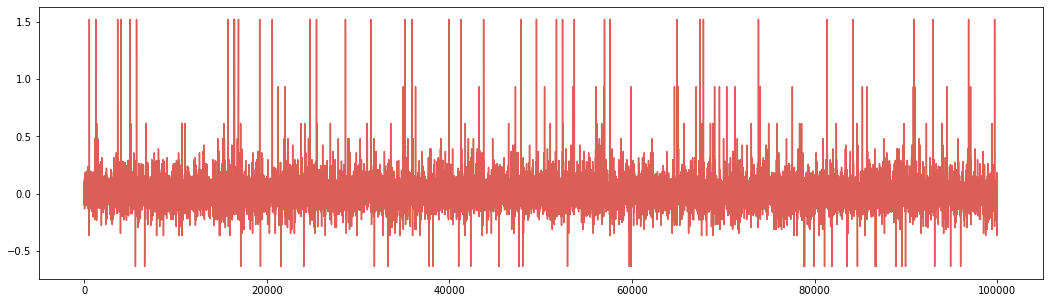

In [14]:
max = pdS['cumul'].max()
print(max)
print('test unitaire du générateur: ',getOptimRandom(max))
# print('test unitaire du générateur: ',getRandomValue(pdS,'cumul','freq','val',max))

nbEchantillon = 100000
print("Test sur",nbEchantillon,'échantillons, soit un équivalent de',round(nbEchantillon/260),'années')
simul = np.ones(nbEchantillon)
for i in tqdm(range(nbEchantillon)):
    simul[i] = (getOptimRandom(max)[0])
    # simul[i] = (getFastRandom(pdS,'cumul','freq','other',max))
    
fig = plt.figure(figsize=(18,5))
plt.plot(simul);

# On passe à la simulation sur 6 mois ...

In [15]:
# initialisation des valeurs de départ
nbEchantillon = 130
max = pdS['cumul'].max()
len = dataPrices['Day-ahead'].size
if (volatilite>0):
    len = volatilite
ancData = np.zeros((101,len))
ancData[0] = dataPrices['Day-ahead'][-volatilite:]
# print('ici',ancData[0].size)
startVal = ancData[0][-1]
startDate = dataPrices['Day-ahead'].index[-1]
forecast=np.zeros((10000,nbEchantillon))
forecastDate = np.empty([nbEchantillon],dtype='object')
for i in tqdm(range(10000)):
    val = startVal
    date = startDate
    # simul = pd.Series([startVal],index=[startDate]);
    simul = np.zeros((130))
    for j in range(nbEchantillon):
        val = (1 + getOptimRandom(max)) * val;
        # val = (1 + getFastRandom(pdS,'cumul','freq','other',max)) * val;
        if (i==0):
            date = date + BusinessDay(1)
            forecastDate[j] = date
        # print(val)
        simul[j] = val[0]
    # print(simul.values)
    forecast[i] = (simul)
print(forecast.shape)
# fig = plt.figure(figsize=(18,8))
# palette = sns.color_palette("Paired")
# sns.set_palette(palette=palette)
# plt.plot(forecast.T[0:3]);

100%|██████████| 10000/10000 [00:03<00:00, 3005.10it/s]

(10000, 130)


35.10259068739494 67.66322147701717 21.362362920272336


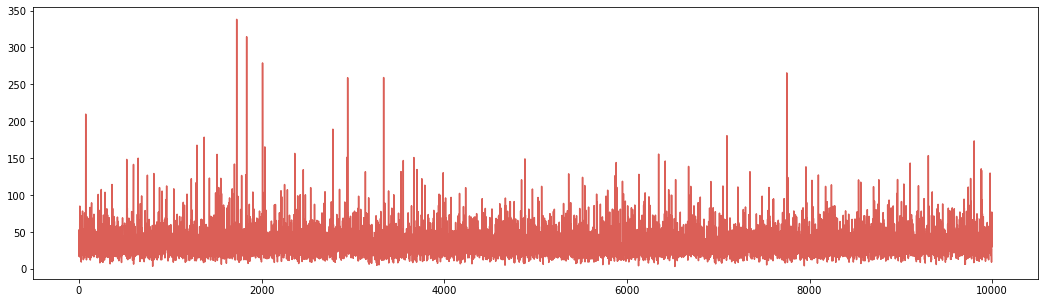

In [16]:
# end = ancData.index[-1]
# val = ancData.loc[startDate+BusinessDay(10)].values
# val = ancData.loc[end].values
val = forecast.T[nbEchantillon-60]
val = val[1:]
fig = plt.figure(figsize=(18,5))
plt.plot(val);
print(val.mean(), np.percentile(val,95),np.percentile(val,20))

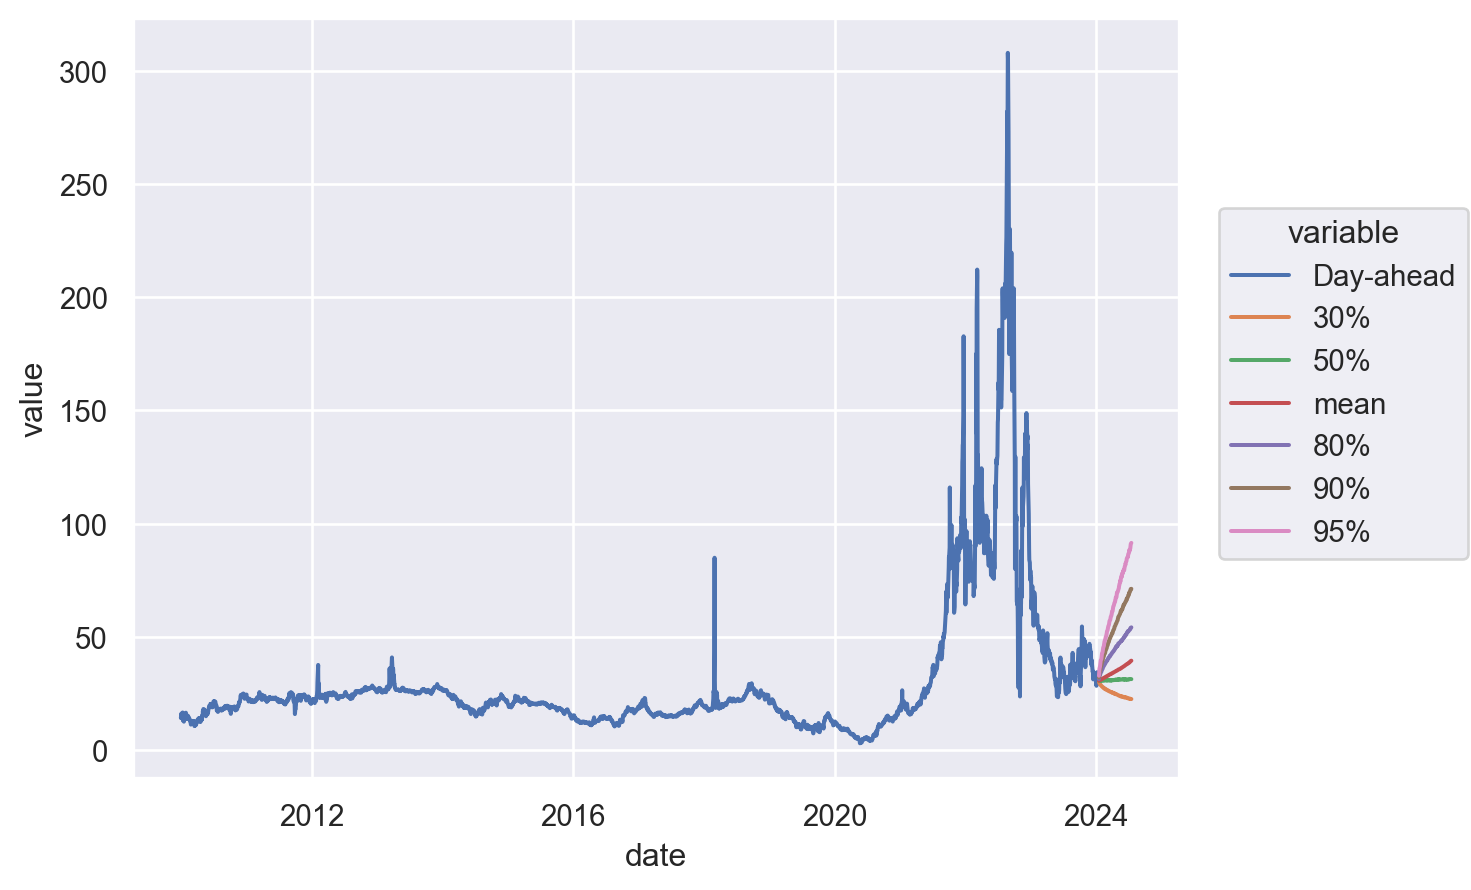

In [17]:
# print(startDate,end)
# print(np.busday_offset(['2024-01-12','2024-07-17'],0))
# print(np.busday_count(np.datetime64(startDate,'D'),np.datetime64(end,'D')))
# count = np.timedelta64(end-startDate,'D').astype(int)
# count = np.busday_count(np.datetime64(startDate,'D'),np.datetime64(end,'D')).astype(int)
# print(count)
# simulUnique = ancData.
canal  = np.empty((6,nbEchantillon))
for i in range(nbEchantillon):
    # val = ancData.loc[startDate+BusinessDay(i)].values
    val = forecast.T[i]
    val = val[1:]
    j=0
    canal[j][i] = np.percentile(val,30)
    j+=1
    canal[j][i] = np.percentile(val,50)
    j+=1
    canal[j][i] = val.mean()
    j+=1
    canal[j][i] = np.percentile(val,80)
    j+=1
    canal[j][i] = np.percentile(val,90)
    j+=1
    canal[j][i] = np.percentile(val,95)
    # print(i,startDate+BusinessDay(i),val.mean())
# mise en forme Pandas
dataForm = pd.DataFrame(data=canal.T,columns=['30%','50%','mean','80%','90%','95%'], index=forecastDate)
dataForm.index.name ='date'
historique = pd.DataFrame(dataPrices['Day-ahead'][-volatilite:])
historique.index.name ='date'
Allvalues = pd.melt(pd.concat([historique,dataForm]),value_vars=['Day-ahead','30%','50%','mean','80%','90%','95%'],ignore_index=False)
# Affichage du graphique
# palette = sns.color_palette("crest")
(
so.Plot(Allvalues,x='date',y='value',color='variable')
.add(so.Line(),so.Agg())
# .scale(
#         x=so.Continuous().tick(every=20)#.label(mdates.DateFormatter('%y-%m'))
#         # y=so.Continuous().label(like="${x:.0f}"),
#         # color=so.Continuous().tick(at=[1, 2, 3, 4]),
#     )
)

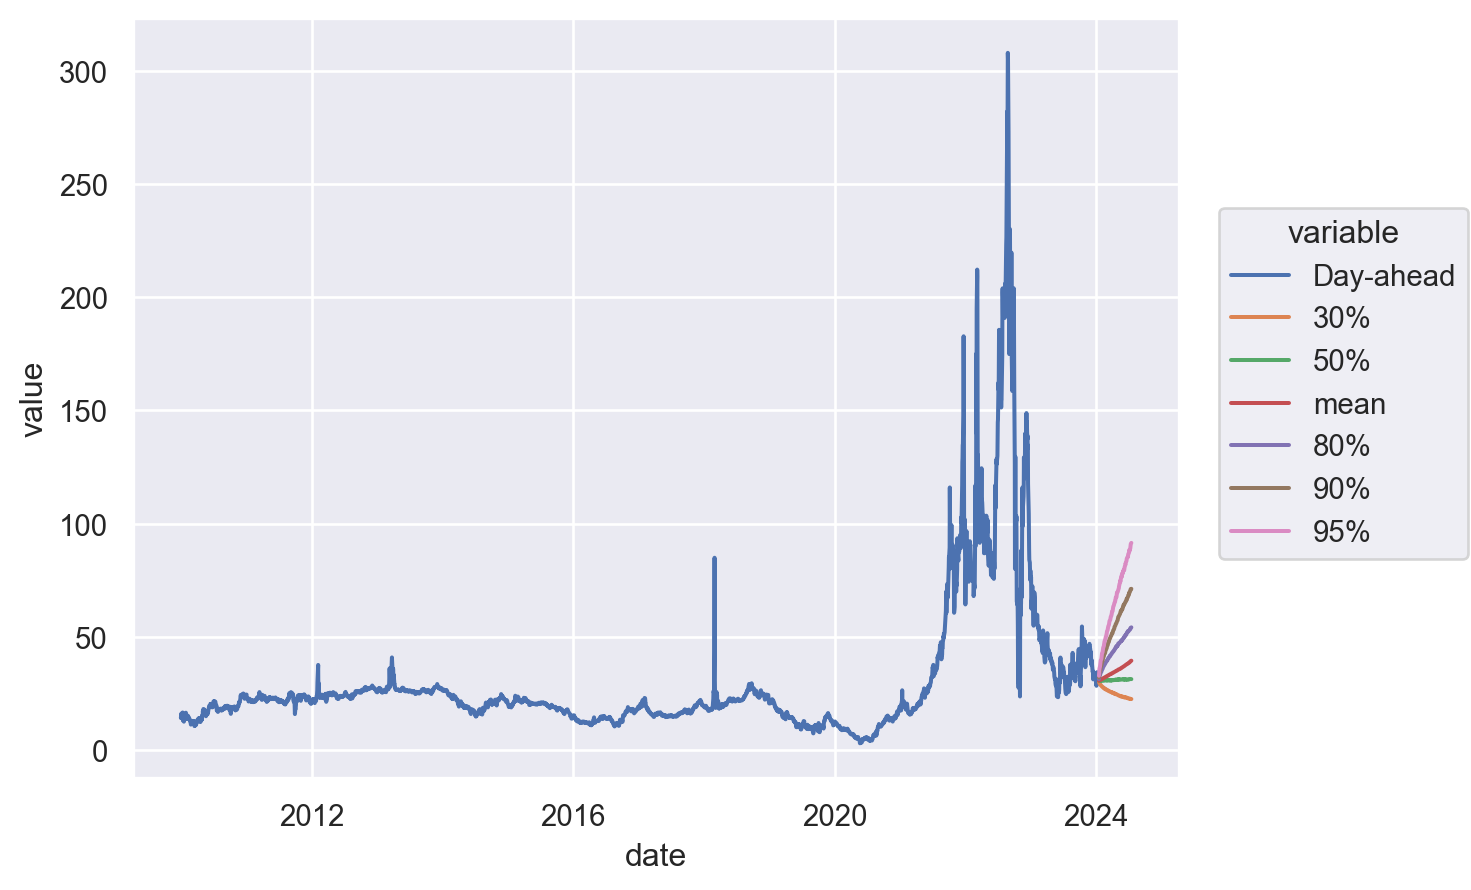

In [18]:
# palette = sns.color_palette("crest")
(
so.Plot(Allvalues,x='date',y='value',color='variable')
.add(so.Line(),so.Agg())
# .scale(
#         x=so.Continuous().tick(every=20)#.label(mdates.DateFormatter('%y-%m'))
#         # y=so.Continuous().label(like="${x:.0f}"),
#         # color=so.Continuous().tick(at=[1, 2, 3, 4]),
#     )
)
